# Statistical Considerations in Test
主要分成兩個主題
1. 統計如何幫助我們設置檢驗
2. 分析檢驗時的常見誤區

# Statistical Significance
本節使用的情況是測驗改變網頁的排版是否會增加點擊下載的比率，控制組與實驗組利用 cookie 分割，且只記錄兩件事
1. 網頁版本，0 為控制組，1 為實驗組
2. 使否在資料收集階段點擊了下載鈕

在做檢驗時要考慮以下兩點
- Invariant metric - 比如說兩組的資料筆數是否類似，這對於我們最後利用Evaluation Metric得到的推論很重要，這一步能確保檢驗的基礎是可靠的。
- Evaluation Metric - 真正要假設檢驗的東西。

In [1]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
data = pd.read_csv('../data/statistical_significance_data.csv')
data.head()

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0


## Invariant metric
### Simulation-base
分類次數是訪問者的人數，假設我們預期50%/50%分類，將試驗重複200000次（兼具速度與變異性），看看之中有幾次屬於50%/50%分類的極端。
由於我們做得是雙尾測試，極端狀況也包括50%/50%分類的另一端，也就是說如果結果0.48和更小的值視為極端，則0.52和更大的值也視為極端，藉此計算 p-value。

$$H_0: \pi_{ctrl} = 0.5$$
$$H_1: \pi_{ctrl} \neq 0.5$$

In [3]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_ctrl = data[data.condition == 0].shape[0]

In [4]:
# simulate outcomes under null
n_trials = 200000
prob = 0.5
np.random.seed(42)
null_dist = np.random.binomial(n_obs, prob, n_trials)

0.613205

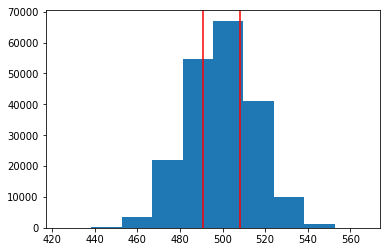

In [5]:
# compare to observed outcome
plt.hist(null_dist)
plt.axvline(n_ctrl, color='r')
plt.axvline(n_obs - n_ctrl, color='r');

p_value = (null_dist <= n_ctrl).mean() + (null_dist >= n_obs - n_ctrl).mean()
p_value

### Analytic Approach

可以使用二項式分布來計算 p-value，但更常見的是使用常態分布（因為central limit theorem），為了得到更準確的值，記得要做 continuity correction，可以在計算曲線下面積前加或減去 0.5，也就是說如果控制組比率為 415/850，常態近似就是左邊的面積 (415+0.5)/850=0.489，右邊的面積 (435−0.5)/850=0.511。

In [6]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [7]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print(z)
print(2 * stats.norm.cdf(z))

-0.5062175977346661
0.6127039025537114


> 可以看出 p-value 很大，所以我們無法拒絕 null，因此可以安心進行Evaluation Metric的測試

## Evaluation Metric

$$H_0: CTR_{exp} - CTR_{ctrl} <= 0$$
$$H_1: CTR_{exp} - CTR_{ctrl} > 0$$

In [8]:
p_click = data.groupby('condition').mean()['click']
p_click

condition
0    0.079430
1    0.112205
Name: click, dtype: float64

### Simulation-base

In [9]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

In [10]:
# simulate outcomes under null, compare to observed outcome
n_trials = 200000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
samples = exp_clicks / n_exper - ctrl_clicks / n_control

print((samples >= (p_click[1] - p_click[0])).mean())

0.0397


### Analytic Approach

In [11]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z = (p_click[1] - p_click[0]) / se_p
print(z)
print(1-stats.norm.cdf(z))

1.7571887396196666
0.039442821974613684


> 可以看出上面的結果拒絕 null，因此新的排版在統計上比舊的還好。